In [26]:
%matplotlib inline
import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (RandomForestRegressor,RandomForestClassifier, IsolationForest)
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import f_regression, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import random as rn
import tensorflow as tf
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
import math
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2
#from imblearn.ensemble import BalancedRandomForestClassifier


TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

seed=42
np.random.seed(seed)
rn.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)



# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



In [27]:
#Load train and test set

train_data = pd.read_csv(TRAIN_FILE_PATH)
train_data.drop(train_data.columns[0], axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop(Y_train.columns[0], axis=1, inplace = True)

test_data =  pd.read_csv(TEST_FILE_PATH)
id_test = test_data.columns[0]
test_data.drop(test_data.columns[0], axis=1, inplace=True)

In [29]:
#Separate samples w.r.t training labels in {0,1,2}

Y_train_0_idx = Y_train.index[Y_train['y'] == 0].tolist()
Y_train_1_idx = Y_train.index[Y_train['y'] == 1].tolist()
Y_train_2_idx = Y_train.index[Y_train['y'] == 2].tolist()

#Select the corresponding samples ad group them per label

Y_train_0 = Y_train.ix[Y_train_0_idx]
Y_train_1 = Y_train.ix[Y_train_1_idx]
Y_train_2 = Y_train.ix[Y_train_2_idx]

X_train_0 = train_data.ix[Y_train_0_idx]
X_train_1 = train_data.ix[Y_train_1_idx]
X_train_2 = train_data.ix[Y_train_2_idx]

print("\nClass 0")
print(X_train_0.shape)
print(Y_train_0.shape)
"""print("Mean: ", list(X_train_0.mean()))"""

print("\nClass 1")
print(X_train_1.shape)
print(Y_train_1.shape)
"""print("Mean: ", list(X_train_1.mean()))"""

print("\nClass 2")
print(X_train_2.shape)
print(Y_train_2.shape)
"""print("Mean: ", list(X_train_2.mean()))"""



Class 0
(600, 1000)
(600, 1)

Class 1
(3600, 1000)
(3600, 1)

Class 2
(600, 1000)
(600, 1)


/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


'print("Mean: ", list(X_train_2.mean()))'

In [31]:
Y_0_vs_all = Y_train.copy()
Y_0_vs_all.ix[Y_train_0_idx] = 1
Y_0_vs_all.ix[Y_train_1_idx] = 0
Y_0_vs_all.ix[Y_train_2_idx] = 0

Y_1_vs_all = Y_train.copy()
Y_1_vs_all.ix[Y_train_0_idx] = 0
Y_1_vs_all.ix[Y_train_1_idx] = 1
Y_1_vs_all.ix[Y_train_2_idx] = 0

Y_2_vs_all = Y_train.copy()
Y_2_vs_all.ix[Y_train_0_idx] = 0
Y_2_vs_all.ix[Y_train_1_idx] = 0
Y_2_vs_all.ix[Y_train_2_idx] = 1

/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [32]:
#Select samples by group of two labels

indices_0_1 = list(np.union1d(Y_train_0_idx, Y_train_1_idx))
X_train_0_1 = train_data.ix[indices_0_1]
Y_train_0_1 = Y_train.ix[indices_0_1]

indices_0_2 = list(np.union1d(Y_train_0_idx, Y_train_2_idx))
X_train_0_2 = train_data.ix[indices_0_2]
Y_train_0_2 = Y_train.ix[indices_0_2]

indices_1_2 = list(np.union1d(Y_train_1_idx, Y_train_2_idx))
X_train_1_2 = train_data.ix[indices_1_2]
Y_train_1_2 = Y_train.ix[indices_1_2]

print("\nClass 0 & 1")
print(X_train_0_1.shape)
print(Y_train_0_1.shape)

print("\nClass 0 & 2")
print(X_train_0_2.shape)
print(Y_train_0_2.shape)

print("\nClass 1 & 2")
print(X_train_1_2.shape)
print(Y_train_1_2.shape)



Class 0 & 1
(4200, 1000)
(4200, 1)

Class 0 & 2
(1200, 1000)
(1200, 1)

Class 1 & 2
(4200, 1000)
(4200, 1)


/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/francesco/anaconda3/lib/python

In [33]:
#Zero mean unit variance for train and test data
def scale_data(train, test):
    
    print("Train shape: ", train.shape)
    print("Test shape: ",test.shape)
    
    scaler = StandardScaler().fit(train, Y_train)
    train = scaler.transform(train)
    test = scaler.transform(test)
   
    return train, test

In [34]:
#Scale each class samles w.r.t its similar (in the same label)

"""print("\n1 vs 1")
X_train_0_1, test_data_mean_scaled = scale_data(X_train_0_1, test_data_mean)
X_train_0_2, test_data_mean_scaled = scale_data(X_train_0_2, test_data_mean)
X_train_1_2, test_data_mean_scaled = scale_data(X_train_1_2, test_data_mean)
"""

print("\n1 vs all")
X_train, X_test = scale_data(train_data, test_data)
print(X_train.shape)
print(X_test.shape)


1 vs all
Train shape:  (4800, 1000)
Test shape:  (4100, 1000)
(4800, 1000)
(4100, 1000)


(4200, 1000)
(4200, 1)


/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


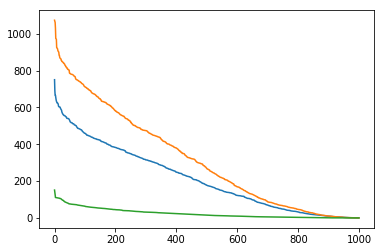

In [35]:
#Extract the features to use with f_classification
# 1 vs 1 label

n_features_fr = 200

print(X_train_0_1.shape)
print(Y_train_0_1.shape)

features_scores_01 = f_classif(X_train_0_1, Y_train_0_1)[0]
features_scores_02 = f_classif(X_train_0_2, Y_train_0_2)[0]
features_scores_12 = f_classif(X_train_1_2, Y_train_1_2)[0]

#print(features_scores)
y_01 = list(features_scores_01)
y_02 = list(features_scores_02)
y_12 = list(features_scores_12)

#print(y)
fc_selection_01 = np.asarray(y_01)
fc_selection_02 = np.asarray(y_02)
fc_selection_12 = np.asarray(y_12)

plt.plot(-1*np.sort(-1*fc_selection_01), label='Labels 0 vs 1'); #Easiest
plt.plot(-1*np.sort(-1*fc_selection_12), label='Labels 1 vs 2');
plt.plot(-1*np.sort(-1*fc_selection_02), label='Labels 0 vs 2'); #Most difficult

indices_fc_01 = fc_selection_01.argsort()[-n_features_fr:][::-1]
indices_fc_12 = fc_selection_12.argsort()[-n_features_fr:][::-1]
indices_fc_02 = fc_selection_02.argsort()[-n_features_fr:][::-1]

#print(indices_fr)
#print(len(indices_fr))

(4800, 1000)
(4800, 1)
Total features selected in common (intersection) between 0 vs 2 and 0 vs all approach:  37


/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


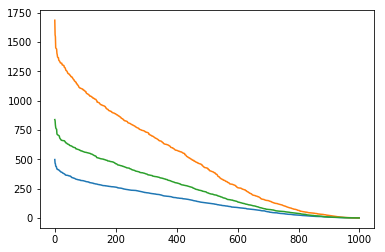

In [36]:
# 1 vs all philosophy
#Extract the features to use with f_classification

n_features_fc = 200

print(X_train.shape)
print(Y_0_vs_all.shape)
#print(Y_0_vs_all)

features_scores_0_vs_all = f_classif(X_train, Y_0_vs_all)[0]
#print(features_scores_0_vs_all)
features_scores_1_vs_all = f_classif(X_train, Y_1_vs_all)[0]
features_scores_2_vs_all = f_classif(X_train, Y_2_vs_all)[0]

#print(features_scores)
y_0_vs_all = list(features_scores_0_vs_all)
y_1_vs_all = list(features_scores_1_vs_all)
y_2_vs_all = list(features_scores_2_vs_all)

#print(y)
f_0_vs_all = np.asarray(y_0_vs_all)
f_1_vs_all = np.asarray(y_1_vs_all)
f_2_vs_all = np.asarray(y_2_vs_all)

plt.plot(-1*np.sort(-1*f_0_vs_all), label='Labels 0 vs all'); #Hardest
plt.plot(-1*np.sort(-1*f_1_vs_all), label='Labels 1 vs all');
plt.plot(-1*np.sort(-1*f_2_vs_all), label='Labels 0 vs all');

indices_fc_0_vs_all = f_0_vs_all.argsort()[-n_features_fc:][::-1]
indices_fc_1_vs_all = f_1_vs_all.argsort()[-n_features_fc:][::-1]
indices_fc_2_vs_all = f_2_vs_all.argsort()[-n_features_fc:][::-1]

#print(indices_fr)
#print(len(indices_fr))

"""print(len(indices_fc_0_vs_all))
print(len(myarray_02))
print(indices_fc_0_vs_all[0:50])
print(myarray_02[0:50])"""

indices_see = list(set(indices_fc_0_vs_all).intersection(indices_fc_02))
print("Total features selected in common (intersection) between 0 vs 2 and 0 vs all approach: ",len(indices_see))


In [37]:
#Extract the feature selected from dataset

#indices = list(set(indices_fr_0_vs_all).intersection(indices_fr_1_vs_all).intersection(indices_fr_2_vs_all))
indices = list(set(indices_fc_0_vs_all).union(indices_fc_1_vs_all).union(indices_fc_2_vs_all))

#print(indices)

print("Total indices selected: ",len(indices))

X_train_subset = train_data[train_data.columns[indices]]
X_test_subset = test_data[train_data.columns[indices]]

#Scale data

X_train_subset, X_test_subset = scale_data(X_train_subset, X_test_subset)

Total indices selected:  281
Train shape:  (4800, 281)
Test shape:  (4100, 281)


In [13]:
def from_class_to_vec(y_list):
    
    Y_vec_list = []
    print("length of list passed ",len(y_list))
    
    for value in y_list:
        if value == 0.0:
            Y_vec_list.append([1,0])
        if value == 1.0:
            Y_vec_list.append([0,1])
            
    #print("Example binary vector ",Y_vec_0_vs_all)
    return np.array(Y_vec_list)


In [23]:
# From labels to probability vectors

y_list = list(Y_0_vs_all['y'])
Y_vec_0_vs_all = from_class_to_vec(y_list)

y_list = list(Y_1_vs_all['y'])
Y_vec_1_vs_all = from_class_to_vec(y_list)

y_list = list(Y_2_vs_all['y'])
Y_vec_2_vs_all = from_class_to_vec(y_list)

print("\nFinal shapes of class vectors:")
print(Y_vec_0_vs_all.shape)
print(Y_vec_1_vs_all.shape)
print(Y_vec_2_vs_all.shape)


length of list passed  4800
length of list passed  4800
length of list passed  4800

Final shapes of class vectors:
(4800, 2)
(4800, 2)
(4800, 2)


In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers
from keras.losses import *
 #from sklearn.metrics import balanced_accuracy_score

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def bmac_metric(y_true, y_pred):
    TPR =  tf.metrics.recall(y_true, y_pred)
    #SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return TPR

# fix random seed for reproducibility
# Parameters

input_dimensions = len(indices)
lambda_reg = 10
num_epochs = 100
dropout = 0

#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#cvscores = []

optimizer = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
print("Input dimensions: ", input_dimensions)

#for train, test in kfold.split(X_train_subset, Y):
# create model
def nn_model():
    
    model = Sequential()
    model.add(Dense(200, input_dim= input_dimensions, kernel_regularizer = regularizers.l1(lambda_reg)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate = dropout))
    model.add(Dense(200, input_dim= input_dimensions, kernel_regularizer = regularizers.l1(lambda_reg)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate = dropout))
    model.add(Dense(100, input_dim= input_dimensions, kernel_regularizer = regularizers.l1(lambda_reg)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate = dropout))
    
    model.add(Dense(2, kernel_regularizer = regularizers.l1(lambda_reg), activation = 'softmax'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[coeff_determination])
    
    return model

NameError: name 'indices' is not defined

In [24]:
# Fit the models

# 0 vs all -> fit new model

model_0_vs_all = nn_model()
model_1_vs_all = nn_model()
model_2_vs_all = nn_model()

model_0_vs_all.fit(x=X_train_subset, y=Y_vec_0_vs_all, epochs=num_epochs, verbose=2, validation_split=0.1, shuffle=True, 
          steps_per_epoch=100, initial_epoch=0, validation_steps=5)

model_1_vs_all.fit(x=X_train_subset, y=Y_vec_1_vs_all, epochs=num_epochs, verbose=2, validation_split=0.1, shuffle=True, 
          steps_per_epoch=100, initial_epoch=0, validation_steps=5)

model_2_vs_all.fit(x=X_train_subset, y=Y_vec_2_vs_all, epochs=num_epochs, verbose=2, validation_split=0.1, shuffle=True, 
          steps_per_epoch=100, initial_epoch=0, validation_steps=5)




NameError: name 'nn_model' is not defined

0.875
0.8729166666666667
0.8833333333333333
0.8770833333333333
0.8708333333333333
0.875
0.875
0.8770833333333333
0.8854166666666666
0.8770833333333333
AVG: BMAC score: 0.8769 (+/- 0.0042)


/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


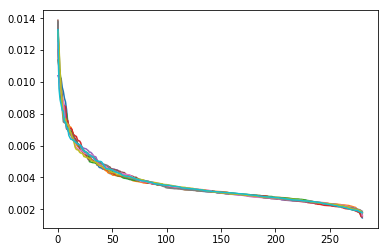

In [222]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import *

BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

Y_0_vs_all_list = Y_0_vs_all['y']

for train, test in kfold.split(X_train_subset, Y_0_vs_all_list ):
    X = X_train_subset[train]
    Y = Y_0_vs_all_list[train]

    model = RandomForestClassifier(n_estimators=100, random_state=seed)
    model.fit(X, Y)
    
    plt.plot((-1*np.sort(-1*np.asarray(model.feature_importances_))))
    
    X_test = X_train_subset[test]
    Y_true = Y_0_vs_all_list.values[test]
    Y_pred = model.predict(X_test)

    # Summary of the predictions made by the classifier
    #print(classification_report(X_test, Y_pred))
    #print(confusion_matrix(Y_test, Y_pred))
    # Accuracy score
    cur_BMAC = accuracy_score(Y_true, Y_pred)
    print(cur_BMAC)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
model.fit(X_train_subset, Y_train.values) # train on all data
pred = model.predict(X_test_subset)
#make_submission('nk_balanced_random_forest_classifier.csv', pred)

In [178]:
c = 0
for val in pred:
    if val == 0:
        c = c+1
print(c)

19
